### Here I will use a logistic regression model and then an artificial neural network which will use the variables below to predict which patients do and do not have heart disease (HD)

The following is a database of 11 medical attributes of 918 patients collected from several hospitals, collated on kaggle.com (https://www.kaggle.com/fedesoriano/heart-failure-prediction)

Attributes include:

Age: age of the patient in years

Sex: (M/F)

ChestPainType: chest pain type (TA: Typical Angina / ATA: Atypical Angina / NAP: Non-Anginal Pain / ASY: Asymptomatic)

RestingBP: resting blood pressure (mm Hg)

Cholesterol: serum cholesterol (mm/dl)

FastingBS: fasting blood sugar (1: if FastingBS > 120 mg/dl / 0: otherwise)

RestingECG: resting electrocardiogram results (Normal: Normal / ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV) / LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria)

MaxHR: maximum heart rate achieved (between 60 and 202 bpm)

ExerciseAngina: exercise-induced angina (Y: Yes / N: No)

Oldpeak: oldpeak = ST (Numeric value measured in depression)

ST_Slope: the slope of the peak exercise stress test segment - tolerance to exercise, flat and down often indicate heart issues
    (Up: upsloping / Flat: flat / Down: downsloping)

HeartDisease:
    0: Patient is healthy /
    1: Patient has heart disease

In [2]:
# load the libraries
import pandas as pd
import numpy as np
import seaborn as sns

In [1]:
# to load data when using google colab
from google.colab import files
uploaded = files.upload()

Saving heart.csv to heart.csv


In [3]:
import io
data = pd.read_csv(io.BytesIO(uploaded['heart.csv']))

In [25]:
# to load the data when using Jupyter notebooks
data = pd.read_csv('heart.csv')

In [5]:
# A glimpse of the variables
data.head()

Age Sex ChestPainType  ...  Oldpeak  ST_Slope  HeartDisease
0   40   M           ATA  ...      0.0        Up             0
1   49   F           NAP  ...      1.0      Flat             1
2   37   M           ATA  ...      0.0        Up             0
3   48   F           ASY  ...      1.5      Flat             1
4   54   M           NAP  ...      0.0        Up             0

[5 rows x 12 columns]

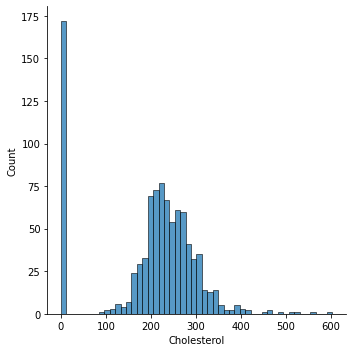

In [6]:
# to start, here we see that a large section of the sample has 0 Cholesterol, which is not possible so these results
# may have originally been nulls
sns.displot(x=data['Cholesterol'],bins=50)

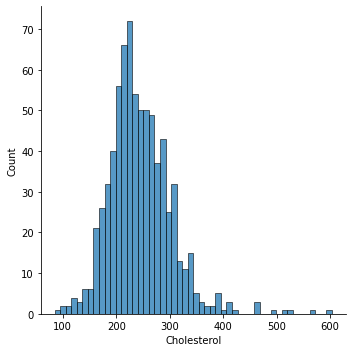

In [28]:
# so such instances are removed
data = data[data['Cholesterol']!=0]
sns.displot(x=data['Cholesterol'],bins=50)

In [29]:
# similarly we see here that one patient apparently has a blood pressure of zero, so we shall omit this one too
view = data[data['RestingBP']==0]
print(view.shape)
data = data[data['RestingBP']!=0]

(0, 12)


#### For the models to be able to interpret the data we must convert the categorical variables listed below into dummies

    - Sex
    - ChestPainType
    - RestingECG
    - ExerciseAngina
    - ST_Slope	

We add n-1 dummies for every category in order to avoid the perfect multicollinearity trap. The 'missing' category is inferred by process of elimination; e.g. we store that a patient is *not* 'M' (M = 0), therefore they must be 'F'.

In [9]:
# dummies for gender, only 'M' is stored
sex = pd.get_dummies(data['Sex'],drop_first=True)
sex.head()

M
0  1
1  0
2  1
3  0
4  1

In [10]:
# making dummies for the remaining variables
ChestPainType = pd.get_dummies(data['ChestPainType'],drop_first=True)
RestingECG = pd.get_dummies(data['RestingECG'],drop_first=True)
ExerciseAngina = pd.get_dummies(data['ExerciseAngina'],drop_first=True)
ST_Slope = pd.get_dummies(data['ST_Slope'],drop_first=True)

In [11]:
# when dropping variables later, here are the columns which were dropped in case we need to replace them
df = pd.get_dummies(data['ChestPainType'],drop_first=False)
Chest_pain_ASY = pd.DataFrame(df['ASY'])
Chest_pain_ASY.rename(columns={'ASY':'ChestPainType - ASY'},inplace=True)


df = pd.get_dummies(data['RestingECG'])
RestingECG_LVH = pd.DataFrame(df['LVH'])
RestingECG_LVH.rename(columns={'LVH':'RestingECG - LVH'},inplace=True)


df = pd.get_dummies(data['ExerciseAngina'],drop_first=False)
ExerciseAngina_No = pd.DataFrame(df['N'])
ExerciseAngina_No.rename(columns={'N':'ExerciseAngina - No'},inplace=True)


df = pd.get_dummies(data['ST_Slope'])
ST_Slope_Down = pd.DataFrame(df['Down'])
ST_Slope_Down.rename(columns={'Down':'ST_Slope - Down'},inplace=True)

In [12]:
# removing the old variables
data.drop(['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope'], axis=1, inplace=True)

In [13]:
# adding back the new ones
datan = data.join((sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope))

In [14]:
# 'Oldpeak' is also omitted because that variable is already expressed by 'ST_Slope'
datan.drop(['Oldpeak'],axis=1, inplace=True)

In [15]:
# For ease of reading we will change the column names
datan = datan.rename(columns={'M': 'Male','ATA':'Chest pain - ATA','NAP':'Chest pain - NAP','TA':'Chest pain - TA',
                             'Normal':'RestingECG - Normal','ST':'RestingECG - ST','Y':'ExerciseAngina - Yes',
                             'Flat':'ST_Slope - Flat','Up':'ST_Slope - Up'})

In [16]:
# all done!
datan.head()

Age  RestingBP  ...  ST_Slope - Flat  ST_Slope - Up
0   40        140  ...                0              1
1   49        160  ...                1              0
2   37        130  ...                0              1
3   48        138  ...                1              0
4   54        150  ...                0              1

[5 rows x 15 columns]

### Building the model

Now the data is interpretable by our models, we may now create the models. First we must split our data into a train/test split, a large slice for the data upon which we create and train our model, and a smaller test slice which the model hasn't seen before, upon which it will attempt to make predictions which we may use to judge its accuracy.

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
y = datan['HeartDisease'] # our dependent variable we are trying to predict is if the patients have heart disease or not
X = datan.drop(columns=['HeartDisease']) # the independent variables are all the variables thought to indicate heart disease

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [19]:
import statsmodels.api as sm
log_reg = sm.Logit(y_train, X_train).fit()
print(log_reg.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Optimization terminated successfully.
         Current function value: 0.347375
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           HeartDisease   No. Observations:                  596
Model:                          Logit   Df Residuals:                      582
Method:                           MLE   Df Model:                           13
Date:                Mon, 08 Nov 2021   Pseudo R-squ.:                  0.4972
Time:                        17:14:13   Log-Likelihood:                -207.04
converged:                       True   LL-Null:                       -411.77
Covariance Type:            nonrobust   LLR p-value:                 2.229e-79
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Age                      0.0131      0.013      0.999      0.318      -0.013       0.039

#### When adopting the 10% level of signficicance, we see the below have p-values which do not meet the 10% threshold for a test if the coefficients are equal to zero (and have no effect). E.g. we have a 31.8% probability of seeing the coefficient we see above for  'RestingBP' if the 'true' coefficient for RestingBP is equal to zero; thus we omit it.

Starting with the one with the highest p-value (i.e., 'Cholesterol' with a p-value of 0.801), variables are removed iteratively until only significant variables remain. Below is the final results of the regression after all redundant variables are removed. You can see the canonical order of removing variables and adding back in the dummies which were removed (albeit both cases 'ST_Slope_Down' and 'RestingECG_LVH' were then removed again).

### Logistic regression results

In [20]:
X_train = X_train.drop(columns=['Cholesterol'])
X_train = X_train.drop(columns=['ST_Slope - Flat'])
X_train = X_train.join(ST_Slope_Down)
X_train = X_train.drop(columns=['RestingBP'])
X_train = X_train.drop(columns=['FastingBS'])
X_train = X_train.drop(columns=['RestingECG - ST'])
X_train = X_train.join(RestingECG_LVH)
X_train = X_train.drop(columns=['RestingECG - LVH'])
X_train = X_train.drop(columns=['RestingECG - Normal'])
X_train = X_train.drop(columns=['ST_Slope - Down'])
X_train = X_train.drop(columns=['MaxHR'])
X_train = X_train.drop(columns=['Age'])


log_reg = sm.Logit(y_train, X_train).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.353754
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           HeartDisease   No. Observations:                  596
Model:                          Logit   Df Residuals:                      590
Method:                           MLE   Df Model:                            5
Date:                Mon, 08 Nov 2021   Pseudo R-squ.:                  0.4880
Time:                        17:14:15   Log-Likelihood:                -210.84
converged:                       True   LL-Null:                       -411.77
Covariance Type:            nonrobust   LLR p-value:                 1.173e-84
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Male                     1.8190      0.251      7.248      0.000       1.327       2.311

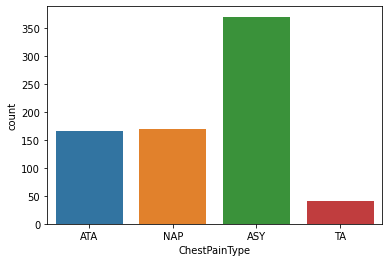

In [30]:
sns.countplot(x='ChestPainType',data=data)

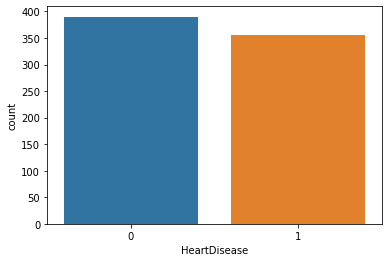

In [31]:
# here we see that the sample is not strongly biased towards HD diagnosis as one might suspect
sns.countplot(x='HeartDisease',data=data)

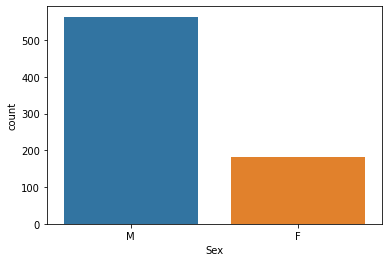

In [32]:
sns.countplot(x='Sex',data=data,)

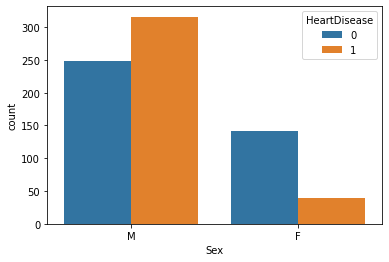

In [33]:
sns.countplot(x='Sex',data=data,hue="HeartDisease")

#### Finally, we have a parsimonious model with only statistically significant regressors.

It is intriguing that the only variables which were positively related to HD are if the patient is male and if the patient has exercise induced angina. It is perhaps to be expected that ‘Male’ has a positive correlation whose strength (1.819) compares to the other variables, as men appear to be more likely to have heart conditions (shorturl.at/eowJ9), something which also appears to be reflected in our data above since males appear to have proportionally higher rates of HD than females. We see a similar result for exercise induced angina with a coefficient of 1.11, as a medical layman I would suppose that angina/chest pain would be part of HD at any point, but the results above indicate that specifically angina from exercise has a strong impact. This makes the negative coefficients of comparable intensity on the other anginal pain variables surprising. Although they are of different strengths, with atypical anginal pain being the strongest at -2.01, then non-anginal pain at -1.45, and typical anginal pain least intense at -1.29. Potentially this is due to a bias of the sample, that is, in the general population the ‘true’ coefficients for measures of chest pain would be positive; on the other hand, as you can see above, most patients are asymptomatic which one would expect in the real population.

The results above suggest that Cholesterol, stress test performance, resting blood pressure, fasting blood sugar, resting electrocardiogram results, maximum heart rate, and age are not significantly able to predict HD. However, this may be an effect of the bias of the sample, whilst those diagnosed with HD are not overrepresented in the sample, these are all individuals who have attended a hospital. It may be that the sample is then biased as not to render the above results, so perhaps whilst they may not be significant for people who are already in hospital, they may become more significant if we were studying random people from the wider general population (i.e., random people brought from the streets). 

Likewise, all results above may be subject to purely random coincidence; for example, like how the divorce rate in Maine being 99% correlated with the per capita consumption of margarine (https://www.tylervigen.com/spurious-correlations).

In [34]:
# here we can see the predicted diagnoses of the model vs. the actual diagnoses

# remove the test data's redundant variables
X_test = X_test.drop(columns=['Cholesterol','ST_Slope - Flat','RestingBP','FastingBS'
                             ,'RestingECG - ST','RestingECG - Normal','MaxHR','Age']) 

y_pred = log_reg.predict(X_test) # run the model on the test data to see what it predicts will be the outcomes (probabilities)
y_pred = np.round(y_pred).astype(int) # probabilities above 50% are converted to '1's and the rest to '0's

preddf = pd.DataFrame(y_pred,columns=['Predictions']) # placing the figures above into a table
preddf = preddf.join(datan['HeartDisease'])
preddf

Predictions  HeartDisease
854            0             0
42             0             0
778            1             1
478            1             1
204            0             0
..           ...           ...
502            1             1
758            0             0
765            0             0
485            1             1
151            0             0

[150 rows x 2 columns]

In [35]:
from sklearn.metrics import classification_report,confusion_matrix

pd.DataFrame(data=confusion_matrix(y_test,y_pred), columns=['Predicted healthy','Predicted disease'], index=['True healthy','True disease'])

Predicted healthy  Predicted disease
True healthy                 63                  9
True disease                  7                 71

In [36]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89        72
           1       0.89      0.91      0.90        78

    accuracy                           0.89       150
   macro avg       0.89      0.89      0.89       150
weighted avg       0.89      0.89      0.89       150



#### We have achieved a model of 89% accuracy

### Predicting HD using a neural network

In [37]:
y = datan['HeartDisease']
X = datan.drop(columns=['HeartDisease'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [38]:
# here we scale the data, setting its mean to 0 and its std.dev. to 1 so that no variable has inordinate influence
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout

In [47]:
model = Sequential()
model.add(Dense(units=14,activation='relu')) # 14 columns so 14 input nodes

# to prevent overfitting, 70% the nodes are switched off at random every epoch. This prevents any particular connection from 
# being 'too' strong, allowing the algorithm to explore different connections
model.add(Dropout(0.7))

model.add(Dense(units=7,activation='relu')) # as a rule of thumb the hidden layer is a size between the input and the output 
model.add(Dropout(0.5))

model.add(Dense(units=1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')

In [48]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=30,
        validation_data=(X_test, y_test), verbose=1
          )

Epoch 1/30
19/19 [==============================] - 1s 10ms/step - loss: 0.9089 - val_loss: 0.8217
Epoch 2/30
19/19 [==============================] - 0s 4ms/step - loss: 0.8386 - val_loss: 0.7645
Epoch 3/30
19/19 [==============================] - 0s 4ms/step - loss: 0.7804 - val_loss: 0.7241
Epoch 4/30
19/19 [==============================] - 0s 3ms/step - loss: 0.7462 - val_loss: 0.6886
Epoch 5/30
19/19 [==============================] - 0s 4ms/step - loss: 0.7311 - val_loss: 0.6621
Epoch 6/30
19/19 [==============================] - 0s 4ms/step - loss: 0.7070 - val_loss: 0.6386
Epoch 7/30
19/19 [==============================] - 0s 3ms/step - loss: 0.6913 - val_loss: 0.6192
Epoch 8/30
19/19 [==============================] - 0s 3ms/step - loss: 0.6723 - val_loss: 0.6041
Epoch 9/30
19/19 [==============================] - 0s 3ms/step - loss: 0.6682 - val_loss: 0.5870
Epoch 10/30
19/19 [==============================] - 0s 4ms/step - loss: 0.6504 - val_loss: 0.5755
Epoch 11/30
19/19 

In [49]:
model_loss = pd.DataFrame(model.history.history)

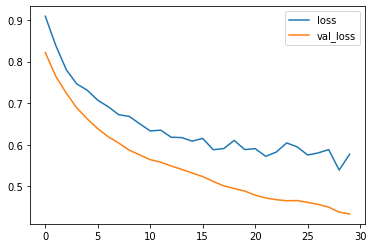

In [50]:
# there is a small degree of overfitting, but after different dropout rates, nodes, and activation functions,
# this sort of performance appears to be what the model is capable of
model_loss.plot()

In [51]:
from sklearn.metrics import classification_report,confusion_matrix

In [52]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)
cm = confusion_matrix(y_test, y_pred)
pd.DataFrame(cm, columns=['Predicted healthy','Predicted disease'], index=['True healthy','True disease'])

Predicted healthy  Predicted disease
True healthy                 61                 11
True disease                  6                 72

In [53]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88        72
           1       0.87      0.92      0.89        78

    accuracy                           0.89       150
   macro avg       0.89      0.89      0.89       150
weighted avg       0.89      0.89      0.89       150



The results above suggest the neural network has essentially the same predictive power as the logistic regression in this task.